In [29]:
# Try to decode which feature was selected per-trial based on firing rates of neurons
# experiment with ranges of firing rates around fixation (selection) time

%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import scipy.stats
from lfp_tools import (
    general as lfp_general,
    startup as lfp_startup,
    development as lfp_development,
    analysis as lfp_analysis
)
from spike_tools import (
    general as spike_general,
    analysis as spike_analysis,
)
import s3fs
import utils.behavioral_utils as behavioral_utils
import utils.spike_utils as spike_utils
import utils.classifier_utils as classifier_utils
import utils.visualization_utils as visualization_utils
import utils.io_utils as io_utils
from trial_splitters.random_splitter import RandomSplitter
from trial_splitters.block_splitter import BlockSplitter
from sklearn import svm
from sklearn.linear_model import LogisticRegression
import pickle

from models.value_models import ValueLinearModel, ValueNormedModel
from models.multinomial_logistic_regressor import MultinomialLogisticRegressor, NormedMultinomialLogisticRegressor
from models.model_wrapper import ModelWrapper

from models.trainer import Trainer

import torch

import plotly.express as px


matplotlib.rcParams['figure.dpi'] = 150


species = 'nhp'
subject = 'SA'
exp = 'WCST'
session = 20180802  # this is the session for which there are spikes at the moment. 

feature_dims = ["Color", "Shape", "Pattern"]

pre_interval = 1300
post_interval = 1500

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
# grab behavioral data, spike data, trial numbers. 
fs = s3fs.S3FileSystem()
behavior_file = spike_general.get_behavior_path(subject, session)
behavior_data = pd.read_csv(fs.open(behavior_file))
valid_beh = behavior_data[behavior_data.Response.isin(["Correct", "Incorrect"])]   
shuffled_card_idxs = behavioral_utils.get_shuffled_card_idxs(valid_beh)

In [23]:
# takes like 2 minutes
lfp = pd.read_csv(fs.open("l2l.jbferre.scratch/for_Patrick/fix.csv"))

/tmp/ipykernel_288257/1821553807.py:2: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  lfp = pd.read_csv(fs.open("l2l.jbferre.scratch/for_Patrick/fix.csv"))


In [20]:
len(lfp.ChanID.unique())

203

In [18]:
np.count_nonzero(np.char.find(lfp.ChanID.unique().astype(str), 'a') == -1)

117

In [24]:
feature_selections = pd.read_pickle(fs.open("l2l.pqz317.scratch/feature_selections.pickle"))


In [4]:
lfp

,Unnamed: 0,TrialNumber,ChanNum,ChanID,TimeBins,bp_4-5,bp_10-13,bp_20-24,bp_27-37,bp_65-87,bp_120-148,raw
0,0,0,0,1,0.0,0.485487,0.421442,1.706493,1.134272,2.001608,1.087065,-0.000010
1,1,0,0,1,0.1,0.616118,0.101362,0.331214,0.800907,0.784997,1.299557,-0.000022
2,2,0,0,1,0.2,0.807149,0.414112,0.916858,0.706293,1.195688,0.485630,-0.000041
3,3,0,0,1,0.3,0.954240,0.366245,0.919632,0.668358,0.513743,2.064996,-0.000020
4,4,0,0,1,0.4,0.854682,1.427809,3.057311,1.246978,1.052312,2.013683,-0.000094
...,...,...,...,...,...,...,...,...,...,...,...,...
9909307,49051,1758,201,9a,2.3,1.790766,0.449447,1.599078,0.873122,0.212149,0.240201,0.000090
9909308,49052,1758,201,9a,2.4,1.527795,0.775098,2.601709,0.800383,0.203501,0.174014,-0.000026
9909309,49053,1758,201,9a,2.5,1.019222,0.453398,1.712471,0.428562,0.484319,0.224563,-0.000091
9909310,49054,1758,201,9a,2.6,0.589201,0.731303,1.202380,0.453108,0.251755,0.088387,-0.000067


In [30]:
valid_lfp = lfp[lfp.TrialNumber.isin(valid_beh.TrialNumber.unique())]

Evaluating for bin 0.0
Evaluating for bin 0.1
Evaluating for bin 0.2
Evaluating for bin 0.30000000000000004
Evaluating for bin 0.4
Evaluating for bin 0.5
Evaluating for bin 0.6000000000000001
Evaluating for bin 0.7000000000000001
Evaluating for bin 0.8
Evaluating for bin 0.9
Evaluating for bin 1.0
Evaluating for bin 1.1
Evaluating for bin 1.2000000000000002
Evaluating for bin 1.3
Evaluating for bin 1.4000000000000001
Evaluating for bin 1.5
Evaluating for bin 1.6
Evaluating for bin 1.7000000000000002
Evaluating for bin 1.8
Evaluating for bin 1.9000000000000001
Evaluating for bin 2.0
Evaluating for bin 2.1
Evaluating for bin 2.2
Evaluating for bin 2.3000000000000003
Evaluating for bin 2.4000000000000004
Evaluating for bin 2.5
Evaluating for bin 2.6
Evaluating for bin 2.7


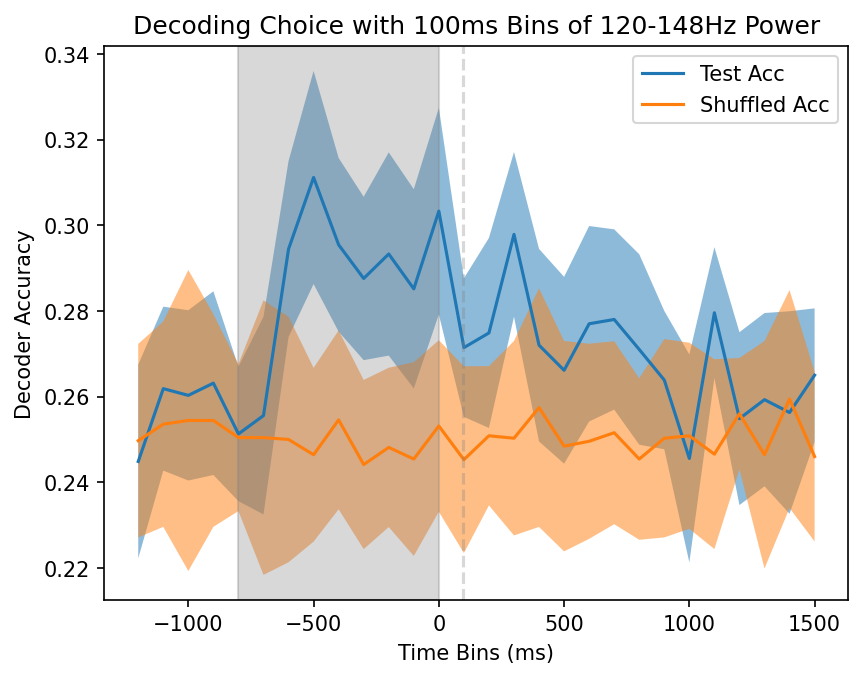

In [13]:
pre_interval = 1300
post_interval = 1500

num_channels = len(valid_lfp.ChanNum.unique())
labels = np.sort(shuffled_card_idxs.ItemChosen.unique())
init_params = {"n_inputs": num_channels, "n_values": 12}
trainer = Trainer(learning_rate=0.05, max_iter=1000)
wrapped = ModelWrapper(ValueLinearModel, init_params, trainer, labels)

mode = "bp_120-148"

# prep data for classification
inputs = valid_lfp.rename(columns={mode: "Value", "ChanNum": "UnitID"})
labels = shuffled_card_idxs.rename(columns={"ItemChosen": "Feature"})

random_splitter = RandomSplitter(labels.TrialNumber.unique(), 20, 0.2)

train_accs_by_bin, test_accs_by_bin, shuffled_accs, models, splits = classifier_utils.evaluate_classifiers_by_time_bins(
    wrapped, inputs, labels, np.arange(0, 2.8, 0.1), random_splitter, cards=shuffled_card_idxs
)

# generate figures
fig, ax = plt.subplots()
visualization_utils.visualize_accuracy_across_time_bins(
    test_accs_by_bin,
    pre_interval, post_interval, 100,
    ax,
    label="Test Acc",
    right_align=True
)
visualization_utils.visualize_accuracy_across_time_bins(
    shuffled_accs,
    pre_interval, post_interval, 100,
    ax,
    label="Shuffled Acc",
    right_align=True
)
ax.axvspan(-800, 0, alpha=0.3, color='gray')
ax.axvline(98, alpha=0.3, color='gray', linestyle='dashed')
ax.set_xlabel("Time Bins (ms)")
ax.set_ylabel("Decoder Accuracy")
ax.set_title(f"Decoding Choice with 100ms Bins of 120-148Hz Power")
ax.legend()

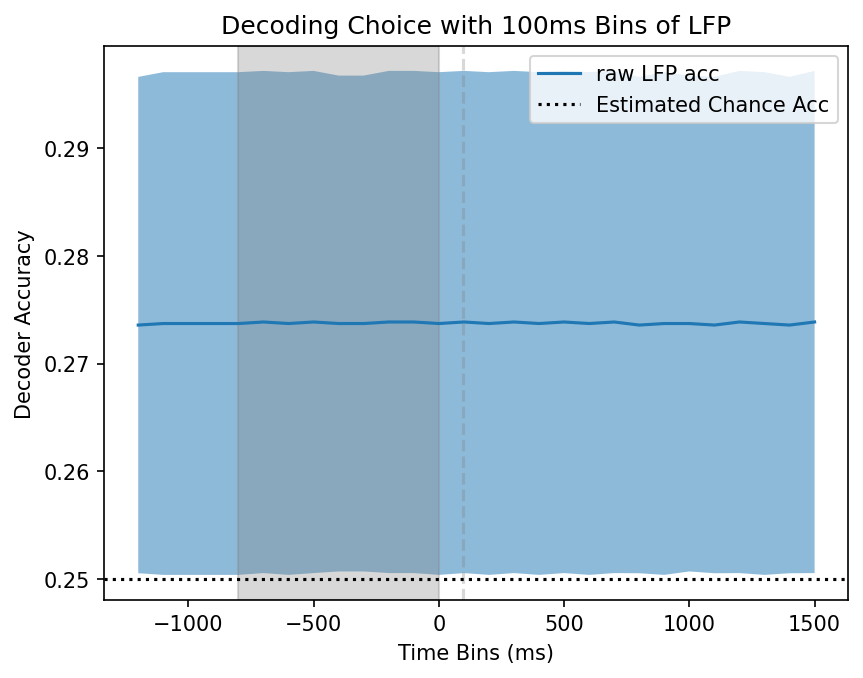

In [4]:
fig, ax = plt.subplots()


acc = np.load(fs.open(f"l2l.pqz317.scratch/value_model_lfp_raw_accs_{pre_interval}_fb_{post_interval}_by_bin_random_split.npy"))

visualization_utils.visualize_accuracy_across_time_bins(
    acc,
    pre_interval, post_interval, 100,
    ax,
    label="raw LFP acc",
    right_align=True
)
ax.axvspan(-800, 0, alpha=0.3, color='gray')
ax.axvline(98, alpha=0.3, color='gray', linestyle='dashed')
ax.axhline(0.25, color='black', linestyle='dotted', label="Estimated Chance Acc")
ax.set_xlabel("Time Bins (ms)")
ax.set_ylabel("Decoder Accuracy")
ax.set_title(f"Decoding Choice with 100ms Bins of LFP")
ax.legend()

### Visualize all freq bands

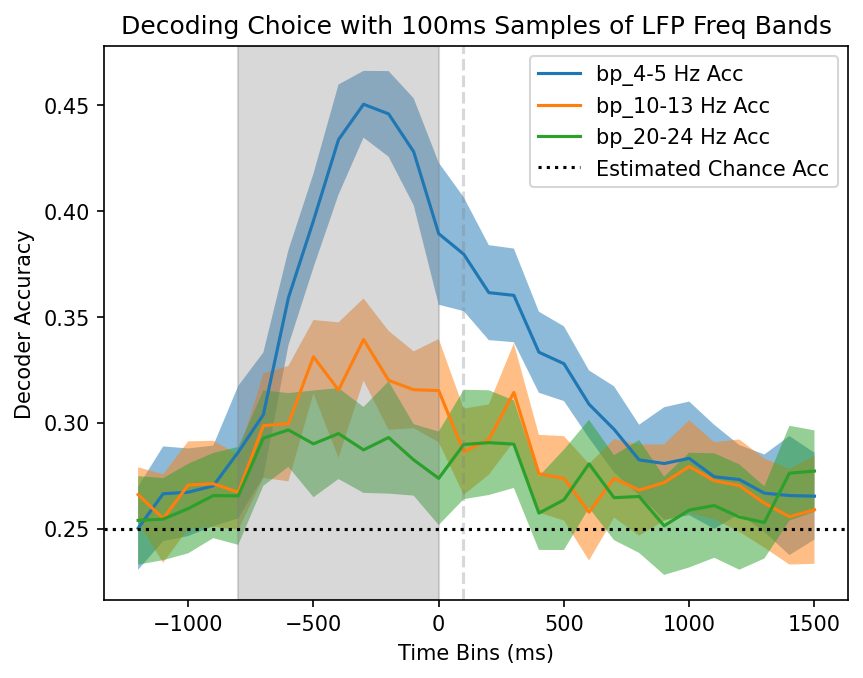

In [31]:
fig, ax = plt.subplots()

# freqs = ["bp_4-5", "bp_10-13", "bp_20-24", "bp_27-37", "bp_65-87", "bp_120-148"]
freqs = ["bp_4-5", "bp_10-13", "bp_20-24"]
for freq in freqs:
    acc = np.load(fs.open(f"l2l.pqz317.scratch/value_model_lfp_{freq}_accs_{pre_interval}_fb_{post_interval}_by_bin_random_split.npy"))
    visualization_utils.visualize_accuracy_across_time_bins(
        acc,
        pre_interval, post_interval, 100,
        ax,
        label=f"{freq} Hz Acc",
        right_align=True,
    )
ax.axvspan(-800, 0, alpha=0.3, color='gray')
ax.axvline(98, alpha=0.3, color='gray', linestyle='dashed')
ax.axhline(0.25, color='black', linestyle='dotted', label="Estimated Chance Acc")
ax.set_xlabel("Time Bins (ms)")
ax.set_ylabel("Decoder Accuracy")
ax.set_title(f"Decoding Choice with 100ms Samples of LFP Freq Bands")
ax.legend()
fig.savefig(f"../data/lfp_choice_lower_bands.pdf")


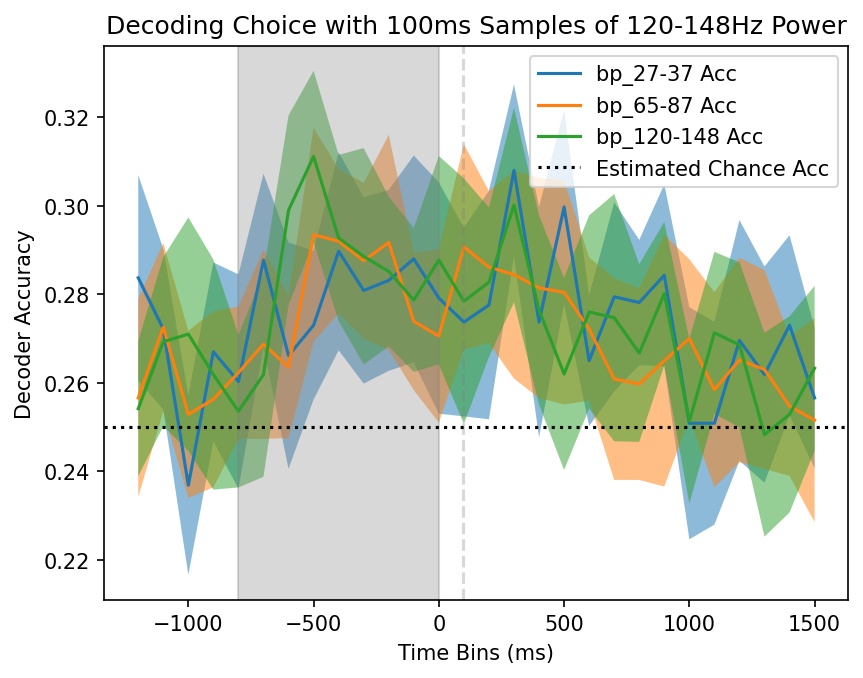

In [33]:
fig, ax = plt.subplots()

freqs = ["bp_27-37", "bp_65-87", "bp_120-148"]
for freq in freqs:
    acc = np.load(fs.open(f"l2l.pqz317.scratch/value_model_lfp_{freq}_accs_{pre_interval}_fb_{post_interval}_by_bin_random_split.npy"))
    visualization_utils.visualize_accuracy_across_time_bins(
        acc,
        pre_interval, post_interval, 100,
        ax,
        label=f"{freq} Acc",
        right_align=True,
    )
ax.axvspan(-800, 0, alpha=0.3, color='gray')
ax.axvline(98, alpha=0.3, color='gray', linestyle='dashed')
ax.axhline(0.25, color='black', linestyle='dotted', label="Estimated Chance Acc")
ax.set_xlabel("Time Bins (ms)")
ax.set_ylabel("Decoder Accuracy")
ax.set_title(f"Decoding Choice with 100ms Samples of LFP Freq Bands")
ax.legend()
fig.savefig(f"../data/lfp_choice_higher_bands.pdf")


### Generate all the feature selection models

In [18]:
freqs = ["bp_4-5", "bp_10-13", "bp_20-24", "bp_27-37", "bp_65-87", "bp_120-148"]
feature_dims = ["Shape", "Pattern"]
for feature_dim in feature_dims:
    for freq in freqs:
        pre_interval = 1300
        post_interval = 1500

        num_channels = len(valid_lfp.ChanNum.unique())
        labels = feature_selections[feature_dim].unique()
        init_params = {"n_inputs": num_channels, "n_classes": len(labels)}
        trainer = Trainer(learning_rate=0.05, max_iter=1000)
        wrapped = ModelWrapper(NormedMultinomialLogisticRegressor, init_params, trainer, labels)

        inputs = valid_lfp.rename(columns={freq: "Value", "ChanNum": "UnitID"})
        labels = feature_selections.rename(columns={feature_dim: "Feature"})

        random_splitter = RandomSplitter(labels.TrialNumber.unique(), 20, 0.2)
        train_accs_by_bin, test_accs_by_bin, shuffled_accs, models, splits = classifier_utils.evaluate_classifiers_by_time_bins(
            wrapped, inputs, labels, np.arange(0, 2.8, 0.1), random_splitter
        )
        np.save(fs.open(f"l2l.pqz317.scratch/{feature_dim}_normed_lr_lfp_{freq}_accs_{pre_interval}_fb_{post_interval}_by_bin_random_split.npy", "wb"), test_accs_by_bin)
        np.save(fs.open(f"l2l.pqz317.scratch/{feature_dim}_normed_lr_lfp_{freq}shuffled_accs_{pre_interval}_fb_{post_interval}_by_bin_random_split.npy", "wb"), shuffled_accs)
        np.save(fs.open(f"l2l.pqz317.scratch/{feature_dim}_normed_lr_lfp_{freq}_models_{pre_interval}_fb_{post_interval}_by_bin_random_split.npy", "wb"), models)
        pickle.dump(splits, fs.open(f"l2l.pqz317.scratch/{feature_dim}_normed_lr_lfp_{freq}_splits_{pre_interval}_fb_{post_interval}_by_bin_random_split.npy", "wb"))      

Evaluating for bin 0.0
Evaluating for bin 0.1
Evaluating for bin 0.2
Evaluating for bin 0.30000000000000004
Evaluating for bin 0.4
Evaluating for bin 0.5
Evaluating for bin 0.6000000000000001
Evaluating for bin 0.7000000000000001
Evaluating for bin 0.8
Evaluating for bin 0.9
Evaluating for bin 1.0
Evaluating for bin 1.1
Evaluating for bin 1.2000000000000002
Evaluating for bin 1.3
Evaluating for bin 1.4000000000000001
Evaluating for bin 1.5
Evaluating for bin 1.6
Evaluating for bin 1.7000000000000002
Evaluating for bin 1.8
Evaluating for bin 1.9000000000000001
Evaluating for bin 2.0
Evaluating for bin 2.1
Evaluating for bin 2.2
Evaluating for bin 2.3000000000000003
Evaluating for bin 2.4000000000000004
Evaluating for bin 2.5
Evaluating for bin 2.6
Evaluating for bin 2.7
Evaluating for bin 0.0
Evaluating for bin 0.1
Evaluating for bin 0.2
Evaluating for bin 0.30000000000000004
Evaluating for bin 0.4
Evaluating for bin 0.5
Evaluating for bin 0.6000000000000001
Evaluating for bin 0.7000000

: 

: 

### Visualize Feature Selection LFP decodability

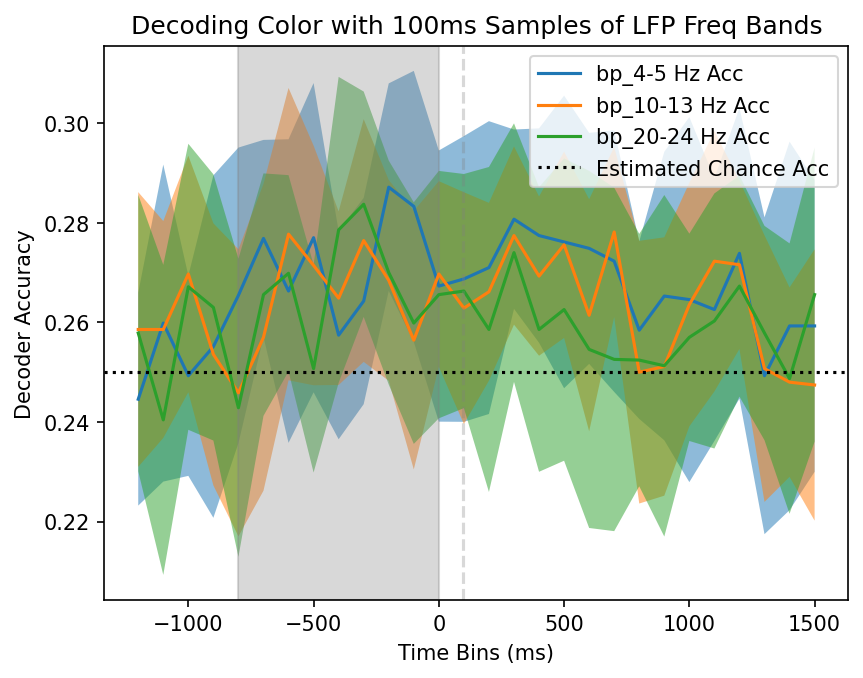

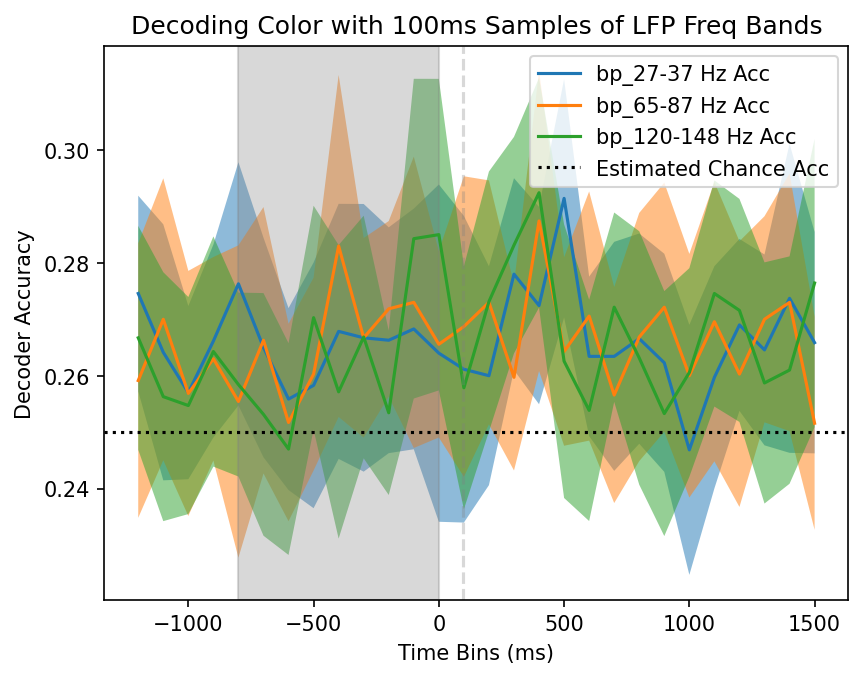

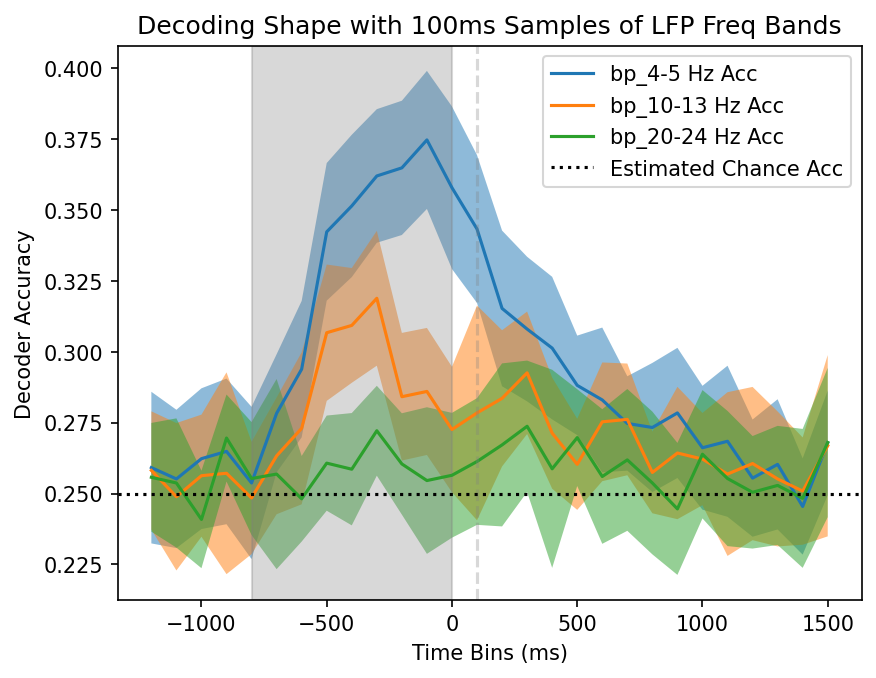

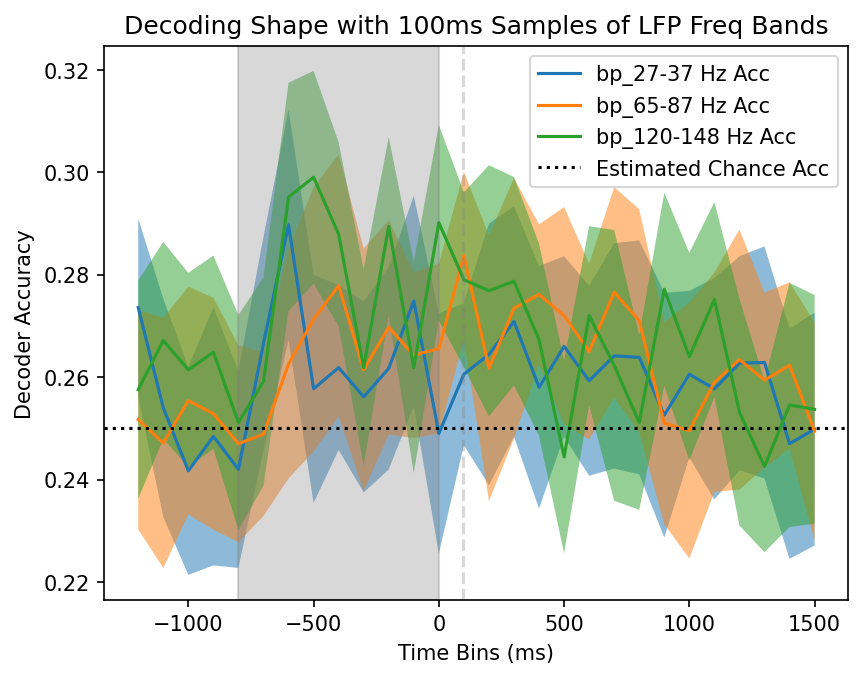

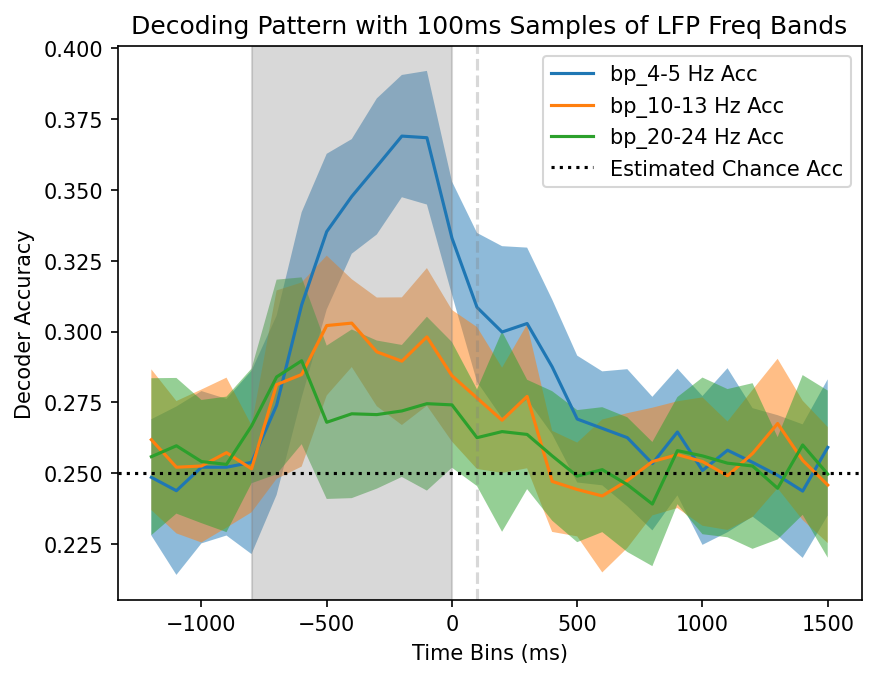

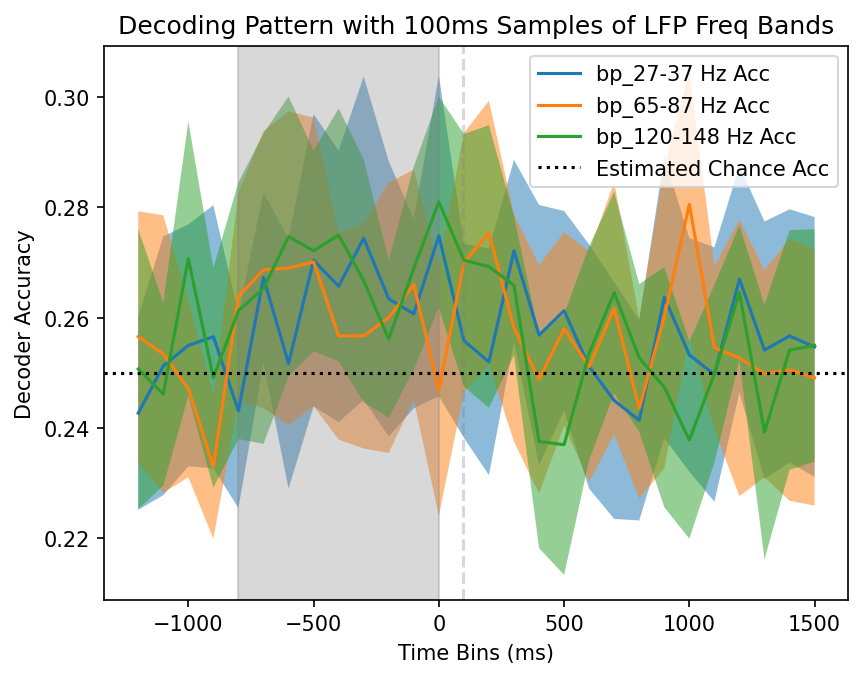

In [34]:
def viz_for_bands(feature_dim, freqs, pre_interval, post_interval, level):
    fig, ax = plt.subplots()
    for freq in freqs:
        acc = np.load(fs.open(f"l2l.pqz317.scratch/{feature_dim}_normed_lr_lfp_{freq}_accs_{pre_interval}_fb_{post_interval}_by_bin_random_split.npy"))
        visualization_utils.visualize_accuracy_across_time_bins(
            acc,
            pre_interval, post_interval, 100,
            ax,
            label=f"{freq} Hz Acc",
            right_align=True,
        )
    ax.axvspan(-800, 0, alpha=0.3, color='gray')
    ax.axvline(98, alpha=0.3, color='gray', linestyle='dashed')
    ax.axhline(0.25, color='black', linestyle='dotted', label="Estimated Chance Acc")
    ax.set_xlabel("Time Bins (ms)")
    ax.set_ylabel("Decoder Accuracy")
    ax.set_title(f"Decoding {feature_dim} with 100ms Samples of LFP Freq Bands")
    ax.legend()
    fig.savefig(f"../data/lfp_{feature_dim}_{level}_bands.pdf")

feature_dims = ["Color", "Shape", "Pattern"]
for feature_dim in feature_dims:
    lower_freqs = ["bp_4-5", "bp_10-13", "bp_20-24"]
    viz_for_bands(feature_dim, lower_freqs, pre_interval, post_interval, "lower")
    higher_freqs = ["bp_27-37", "bp_65-87", "bp_120-148"]
    viz_for_bands(feature_dim, higher_freqs, pre_interval, post_interval, "higher")


